C:\Users\AdminSi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if __name__ == '__main__':


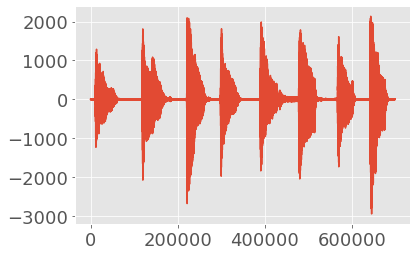

[481.5]


'\n'

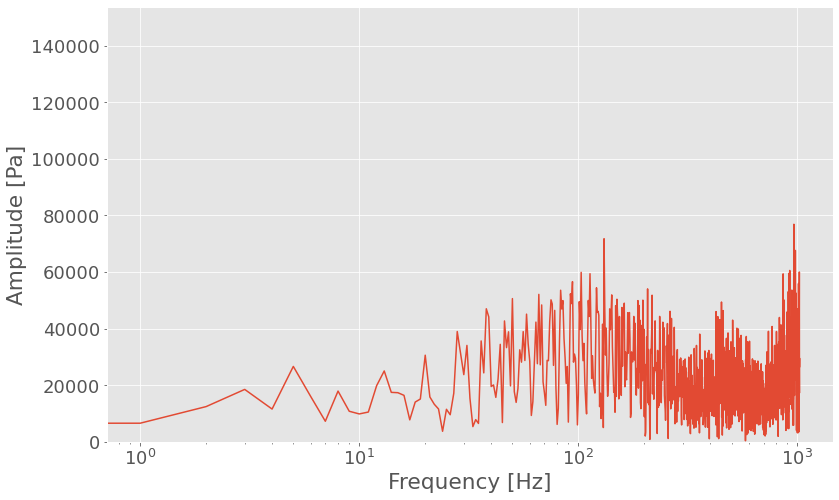

In [4]:
# Importing audio files and all necessary libraries 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fftpack import fft
from thinkdsp import read_wave
import pyaudio 

rate, data = wav.read('S_solfege.wav')
data = data[:,1]


data_abs = np.abs(data)
data_std = np.zeros(len(data))
data_chg = np.zeros(len(data))

''' 
n  = 1000 # range 
for i in range(n,len(data_abs)-n): 
    data_std[i] = np.std(data_abs[i-n:i+n])

    
for i in range(1,len(data_abs)-1): 
    if data_abs[i-1]<data_abs[i] and data_abs[i+1]<data_abs[i]:
        data_chg[i] = 1

# find the maximum 
'''

index = np.arange(0,len(data))
pt1 = plt.plot(index,(data))
plt.show()


lim = 1024
f_vec = np.arange(lim) # frequency vector based on window size and sample rate
fft_data = (np.abs(np.fft.fft(data))[0:int(np.floor(lim))])

# plot
plt.style.use('ggplot')
plt.rcParams['font.size']=18
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111)
plt.plot(f_vec,fft_data)
ax.set_ylim([0,2*np.max(fft_data)])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [Pa]')
ax.set_xscale('log')
plt.grid(True)



num = np.max(fft_data)
freq = f_vec[np.where(fft_data ==num)]

print(freq/2)
'''
'''

In [31]:
# Find the maximum location of those standard deviation 
''' 
max_chg = np.max(data_chg)
# percentage 
ratio = 0.4
indx = np.argwhere(data_chg>ratio*max_chg) 
'''
indx = np.argwhere(data_chg==1)

print(len(indx))
'''
''' 
print(indx.all())

129504
True


In [79]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

x = [1,1,5,6,1,5,10,22,23,23,50,51,51,52,100,112,130,500,512,600,12000,12230]

X = np.array(zip(x,np.zeros(len(x))), dtype=np.int)
bandwidth = estimate_bandwidth(X, quantile=0.1)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'zip'

In [49]:
def find_freq(segment): # Return the frequency of a segment 
    lim = 2**11

    data = segment
    
    
    index = np.arange(0,len(data))
    ''' 
    pt1 = plt.plot(index,(data))
    plt.show()
    ''' 
    f_vec = np.arange(lim/2) # frequency vector based on window size and sample rate
    fft_data = (np.abs(np.fft.fft(data))[0:int(np.floor(lim/2))])
    #fft_data[1:] = 2*fft_data[1:]


    num = np.max(fft_data)

    freq = f_vec[np.where(fft_data ==num)]
    return freq


(rate, sig) = wav.read('S_Solfege.wav')
''' 
Div = 1
seg = int(len(sig)/Div)
while start<len(sig):
    end = start + seg 
    segment = sig[start:end,0]
    print(find_freq(segment))
    start = end 
'''
indices = np.array([0.24, 2.463, 4.6, 6.216, 8.105, 9.946, 11.808, 13.337, len(sig)/rate])

indices = np.int_(indices*rate)
print(indices)
 
for i in range(len(indices)-1):
    segment = sig[indices[i]:indices[i+1],1]
    
    print(Spectrum.find_fundamental_freq(segment))
    #rint(find_freq(segment)) 

'''
'''

[ 11520 118224 220799 298368 389040 477408 566784 640176 698262]
218.31683168316832
331.57894736842104
787.5
469.1489361702128
218.31683168316832
292.05298013245033
648.5294117647059
201.36986301369862


'\n'

In [46]:
# Video info
import time
import itertools
from collections import deque


FFT_SIZE = 1024
WINDOW_SIZE = 2048
THRESHOLD_WINDOW_SIZE = 11
THRESHOLD_MULTIPLIER = 10

DEFAULT_BPM = 120
DEFAULT_PITCH = 64
DEFAULT_VELOCITY = 64

RING_BUFFER_SIZE = 40
FRAMES_PER_BUFFER = 4096
SAMPLE_RATE = 44100


class SpectralAnalyser(object):

    FREQUENCY_RANGE = (200, 800)

    def __init__(self, window_size, segments_buf=None):
        self._window_size = window_size
        if segments_buf is None:
            segments_buf = int(SAMPLE_RATE / window_size)
        self._segments_buf = segments_buf

        self._thresholding_window_size = THRESHOLD_WINDOW_SIZE
        assert self._thresholding_window_size <= segments_buf

        self._last_spectrum = np.zeros(window_size, dtype=np.int16)
        self._last_flux = deque( np.zeros(segments_buf, dtype=np.int16), segments_buf)
        self._last_prunned_flux = 0

        self._hanning_window = np.hanning(window_size)
        # The zeros which will be used to double each segment size
        self._inner_pad = np.zeros(window_size)

        # To ignore the first peak just after starting the application
        self._first_peak = True

    def _get_flux_for_thresholding(self):
        return list(itertools.islice(
            self._last_flux,
            self._segments_buf - self._thresholding_window_size,
            self._segments_buf))

    def find_onset(self, spectrum):
        """
        Calculates the difference between the current and last spectrum,
        then applies a thresholding function and checks if a peak occurred.
        """
        last_spectrum = self._last_spectrum
        flux = sum([max(spectrum[n] - last_spectrum[n], 0)
            for n in xrange(self._window_size)])
        self._last_flux.append(flux)

        thresholded = np.mean(
            self._get_flux_for_thresholding()) * THRESHOLD_MULTIPLIER
        prunned = flux - thresholded if thresholded <= flux else 0
        peak = prunned if prunned > self._last_prunned_flux else 0
        self._last_prunned_flux  = prunned
        return peak

    def find_fundamental_freq(self, samples):
        cepstrum = self.cepstrum(samples)
        # search for maximum between 0.08ms (=1200Hz) and 2ms (=500Hz)
        # as it's about the recorder's frequency range of one octave
        min_freq, max_freq = self.FREQUENCY_RANGE
        start = int(SAMPLE_RATE / max_freq)
        end = int(SAMPLE_RATE / min_freq)
        narrowed_cepstrum = cepstrum[start:end]

        peak_ix = narrowed_cepstrum.argmax()
        freq0 = SAMPLE_RATE / (start + peak_ix)

        if freq0 < min_freq or freq0 > max_freq:
            # Ignore the note out of the desired frequency range
            return

        return freq0

    def process_data(self, data):
        spectrum = self.autopower_spectrum(data)

        onset = self.find_onset(spectrum)
        self._last_spectrum = spectrum

        if self._first_peak:
            self._first_peak = False
            return

        if onset:
            freq0 = self.find_fundamental_freq(data)
            return freq0

    def autopower_spectrum(self, samples):
        """
        Calculates a power spectrum of the given data using the Hamming window.
        """
        # TODO: check the length of given samples; treat differently if not
        # equal to the window size

        windowed = samples * self._hanning_window
        # Add 0s to double the length of the data
        padded = np.append(windowed, self._inner_pad)
        # Take the Fourier Transform and scale by the number of samples
        spectrum = np.fft.fft(padded) / self._window_size
        autopower = np.abs(spectrum * np.conj(spectrum))
        return autopower[:self._window_size]

    def cepstrum(self, samples):
        """
        Calculates the complex cepstrum of a real sequence.
        """
        spectrum = np.fft.fft(samples)
        log_spectrum = np.log(np.abs(spectrum))
        cepstrum = np.fft.ifft(log_spectrum).real
        return cepstrum

    
Spectrum = SpectralAnalyser(WINDOW_SIZE, None)

